<a href="https://colab.research.google.com/github/ProgramasParaFisicaDeParticulas/DelPerceptonAlQubit/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importar librerías y declaración de funciones auxiliares

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec
from tensorflow.keras.optimizers import SGD
import scipy.stats

In [ ]:
color_magenta = '#E91E63'    # Magenta principal
color_azul = '#2196F3'       # Azul medio
color_cyan = '#00BCD4'       # Cyan/turquesa
color_violeta = "#A816C2"    # Violeta
color_verde = '#4CAF50'      # Verde complementario

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 12

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
def configurar_entrenamiento(autoencoder, learning_rate=0.001):
    """
    Configura el autoencoder para entrenamiento

    Parámetros:
    - autoencoder: Modelo del autoencoder
    - learning_rate: Tasa de aprendizaje
    """

    optimizer = SGD(learning_rate=learning_rate)

    autoencoder.compile(
        optimizer=optimizer,
        loss='mse',  # Mean Squared Error
        metrics=['mse']  # Métricas adicionales
    )

    return autoencoder

def visualizar_progreso_entrenamiento(autoencoder, encoder, decoder,
                                      x_train, y_train, x_test, y_test,
                                      epoch, history=None):
    """
    Visualiza el progreso del entrenamiento del autoencoder con layout corregido
    """
    clear_output(wait=True)

    fig = plt.figure(figsize=(24, 16))
    gs = gridspec.GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title(f'Reconstrucciones - Época {epoch}', fontsize=16, fontweight='bold', pad=20)
    ax1.axis('off')

    n_ejemplos = 4
    np.random.seed(42)
    indices_ejemplo = np.random.choice(len(x_test), n_ejemplos, replace=False)
    imagenes_ejemplo = x_test[indices_ejemplo]

    reconstrucciones = autoencoder.predict(imagenes_ejemplo, verbose=0)

    for i in range(n_ejemplos):
        ax_orig = plt.subplot(gs[0, i])
        plt.imshow(imagenes_ejemplo[i].reshape(28, 28), cmap='gray')
        plt.title(f'Original {y_test[indices_ejemplo[i]]}', fontsize=10,
                 color=color_azul if y_test[indices_ejemplo[i]] == 0 else color_magenta)
        plt.axis('off')

        ax_rec = plt.subplot(gs[1, i])
        plt.imshow(reconstrucciones[i].reshape(28, 28), cmap='gray')
        plt.title(f'Reconstruida', fontsize=10, color=color_verde)
        plt.axis('off')

    ax2 = fig.add_subplot(gs[2:, :2])

    latent_repr = encoder.predict(x_test, verbose=0)

    for clase in [0, 1]:
        mask = y_test == clase
        color = color_azul if clase == 0 else color_magenta
        label = f'Clase {clase} (dígito)'

        ax2.scatter(latent_repr[mask, 0], latent_repr[mask, 1],
                   c=color, alpha=0.7, s=40, label=label)

    ax2.set_xlabel('Dimensión Latente 1', fontsize=12)
    ax2.set_ylabel('Dimensión Latente 2', fontsize=12)
    ax2.set_title('Espacio Latente 2D', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor('#FAFAFA')

    ax3 = fig.add_subplot(gs[2:, 2:])

    if history and hasattr(history, 'history') and 'loss' in history.history and len(history.history['loss']) > 1:
        epochs_list = range(1, len(history.history['loss']) + 1)

        ax3.plot(epochs_list, history.history['loss'],
                color=color_violeta, linewidth=2, label='Entrenamiento')

        if 'val_loss' in history.history:
            ax3.plot(epochs_list, history.history['val_loss'],
                    color=color_cyan, linewidth=2, label='Validación')

        ax3.set_xlabel('Época', fontsize=12)
        ax3.set_ylabel('MSE Loss', fontsize=12)
        ax3.set_title('Evolución de la Pérdida', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_facecolor('#FAFAFA')

        ultimo_loss = history.history['loss'][-1]
        ax3.text(0.02, 0.98, f'Último Loss: {ultimo_loss:.4f}',
                transform=ax3.transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax3.text(0.5, 0.5, 'Iniciando entrenamiento...',
                ha='center', va='center', transform=ax3.transAxes,
                fontsize=14, color='#666666')
        ax3.set_title('Evolución de la Pérdida', fontsize=14, fontweight='bold')


    plt.show()


class VisualizacionCallback(tf.keras.callbacks.Callback):
    def __init__(self, autoencoder, encoder, decoder, x_train, y_train, x_test, y_test, frecuencia=10):
        super().__init__()
        self.autoencoder = autoencoder
        self.encoder = encoder
        self.decoder = decoder
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.frecuencia = frecuencia

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frecuencia == 0:
            visualizar_progreso_entrenamiento(
                self.autoencoder, self.encoder, self.decoder,
                self.x_train, self.y_train, self.x_test, self.y_test,
                epoch + 1, self.model.history if hasattr(self.model, 'history') else None
            )

def generar_imagen_personalizada(decoder, x_coord, y_coord):
    """
    Genera una imagen desde coordenadas específicas del espacio latente

    Parámetros:
    - decoder: Modelo decodificador
    - x_coord: Coordenada X en el espacio latente
    - y_coord: Coordenada Y en el espacio latente
    """

    fig = plt.figure(figsize=(20, 9))
    gs = gridspec.GridSpec(1, 2, figure=fig, hspace=0.4, wspace=0.3)

    ax1 = fig.add_subplot(gs[0])

    # Crear punto en espacio latente
    latent_point = np.array([[x_coord, y_coord]])

    # Generar imagen
    imagen_generada = decoder.predict(latent_point, verbose=0)[0]

    plt.imshow(imagen_generada.reshape(28, 28), cmap='gray')
    plt.title(f'Imagen Generada desde ({x_coord:.2f}, {y_coord:.2f})',
              fontsize=14, fontweight='bold')
    plt.axis('off')

    ax2 = fig.add_subplot(gs[1])
    latent_repr = encoder.predict(x_test, verbose=0)

    for clase in [0, 1]:
        mask = y_test == clase
        color = color_azul if clase == 0 else color_magenta
        label = f'Clase {clase} (dígito)'

        ax2.scatter(latent_repr[mask, 0], latent_repr[mask, 1],
                   c=color, alpha=0.7, s=40, label=label)

    ax2.set_xlabel('Dimensión Latente 1', fontsize=12)
    ax2.set_ylabel('Dimensión Latente 2', fontsize=12)
    ax2.set_title('Espacio Latente 2D', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor('#FAFAFA')
    ax2.plot(*latent_point[0], 'x', color='red', markersize=15, markeredgewidth=3, label='Centro')

    plt.show()

    return imagen_generada

# Autoencoders - Aprendiendo Representaciones Comprimidas

## Objetivos de este Notebook

Este notebook presenta una implementación didáctica de **autoencoders** utilizando TensorFlow, diseñada para comprender los conceptos fundamentales del aprendizaje de representaciones y la compresión de datos. Los objetivos son:

1. **Comprender la arquitectura del autoencoder** - Codificador y decodificador
2. **Implementar un autoencoder desde cero** con TensorFlow
3. **Usar el dataset MNIST** con solo 2 clases para análisis profundo
4. **Visualizar el espacio latente** y su capacidad de representación
5. **Generar nuevas imágenes** a partir del espacio latente aprendido
6. **Explorar interactivamente** la estructura del autoencoder
7. **Demostrar la compresión de información** sin pérdida significativa

## Arquitectura del Autoencoder

### Estructura General:
```
Imagen Original (28x28=784) → Codificador → Espacio Latente (2D) → Decodificador → Imagen Reconstruida (28x28=784)
```

### Componentes Principales:

#### 1. **Codificador (Encoder)**
- Comprime la imagen de entrada a una representación de menor dimensión
- Función: `h = f(x)` donde `h` es la representación latente
- Arquitectura: 784 → 128 → 64 → 2

#### 2. **Espacio Latente (Latent Space)**
- Representación comprimida de dimensión 2 (para visualización)
- Contiene las características más importantes de la imagen
- Permite interpolación y generación de nuevas imágenes

#### 3. **Decodificador (Decoder)**
- Reconstruye la imagen original a partir del espacio latente
- Función: `x̂ = g(h)` donde `x̂` es la imagen reconstruida
- Arquitectura: 2 → 64 → 128 → 784

### Función de Costo

Utilizamos **Mean Squared Error (MSE)** como función de pérdida:

$$L = \frac{1}{n} \sum_{i=1}^{n} ||x_i - x̂_i||^2$$

Donde:
- `x_i` es la imagen original
- `x̂_i` es la imagen reconstruida
- `n` es el número de ejemplos

### Optimización

- **Optimizador**: Gradient Descent (SGD)
- **Objetivo**: Minimizar la diferencia entre imagen original y reconstruida
- **Resultado**: Aprender representaciones comprimidas pero informativas

## Conceptos Clave a Explorar

### 1. **Compresión de Información**
- Reducir 784 dimensiones a solo 2
- Mantener la información esencial
- Demostrar que no toda la información es necesaria

### 2. **Espacio Latente**
- Visualización 2D del espacio de características
- Interpolación entre puntos
- Generación de nuevas imágenes

### 3. **Reconstrucción**
- Calidad de la reconstrucción vs compresión
- Análisis visual de las diferencias
- Métricas cuantitativas

### 4. **Generalización**
- Capacidad de reconstruir imágenes no vistas
- Robustez del espacio latente aprendido
- Limitaciones y casos extremos

---

## 1. Carga y Preprocesamiento de Datos MNIST

Para este análisis didáctico, utilizaremos **solo 2 clases** del dataset MNIST:
- **Clase 0**: Dígitos "0"
- **Clase 1**: Dígitos "1"

### ¿Por qué solo 2 clases?

1. **Simplicidad**: Permite visualizar claramente el espacio latente 2D
2. **Interpretabilidad**: Fácil entender cómo se separan las clases
3. **Análisis profundo**: Concentrarnos en los conceptos fundamentales
4. **Visualización**: Espacio latente 2D permite gráficos intuitivos

### Preprocesamiento

1. **Normalización**: Valores entre 0 y 1 para mejor convergencia
2. **Reshape**: Convertir imágenes 28x28 a vectores de 784 elementos
3. **Filtrado**: Seleccionar solo las clases 0 y 1
4. **Mezclado**: Aleatorizar el orden de los datos

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


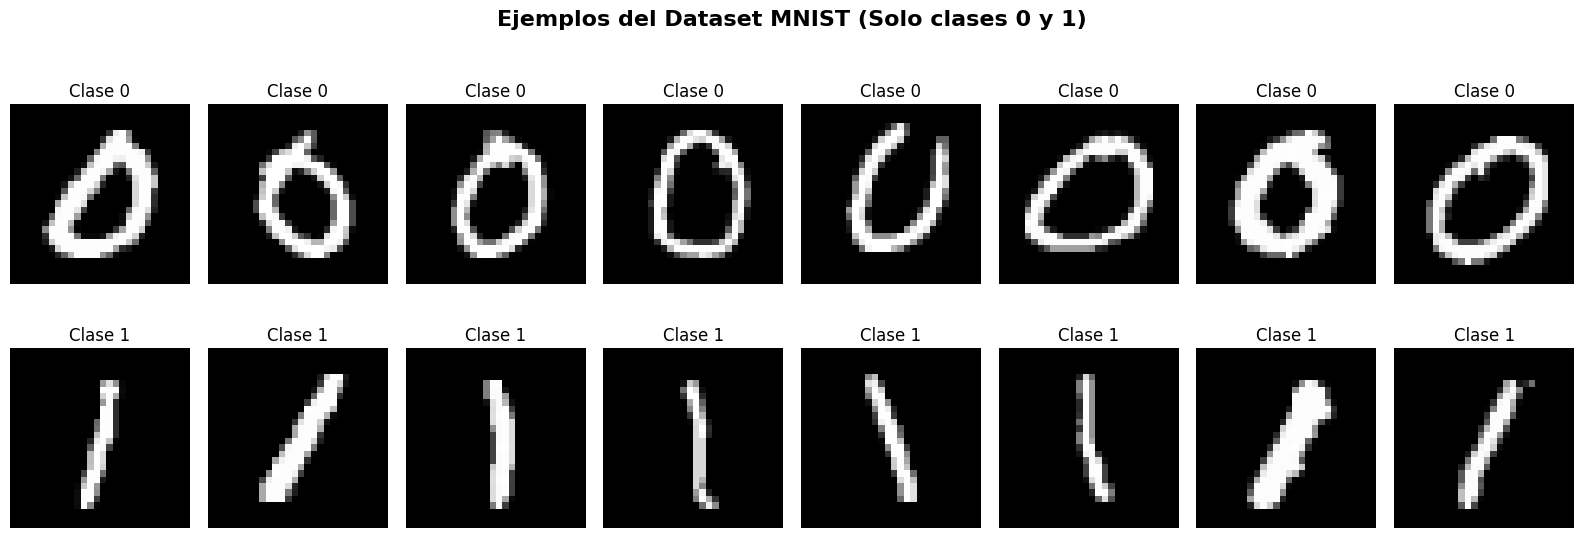

In [ ]:
def cargar_y_preprocesar_mnist():
    """
    Carga el dataset MNIST y lo preprocesa para el autoencoder
    Retorna solo las clases 0 y 1 para análisis simplificado
    """
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    mask_train = (y_train == 0) | (y_train == 1)
    x_train_filtered = x_train[mask_train]
    y_train_filtered = y_train[mask_train]

    mask_test = (y_test == 0) | (y_test == 1)
    x_test_filtered = x_test[mask_test]
    y_test_filtered = y_test[mask_test]

    x_train_norm = x_train_filtered.astype('float32') / 255.0
    x_test_norm = x_test_filtered.astype('float32') / 255.0

    x_train_flat = x_train_norm.reshape(len(x_train_norm), -1)
    x_test_flat = x_test_norm.reshape(len(x_test_norm), -1)

    indices_train = np.random.permutation(len(x_train_flat))
    indices_test = np.random.permutation(len(x_test_flat))

    x_train_final = x_train_flat[indices_train]
    y_train_final = y_train_filtered[indices_train]
    x_test_final = x_test_flat[indices_test]
    y_test_final = y_test_filtered[indices_test]


    return (x_train_final, y_train_final), (x_test_final, y_test_final)

(x_train, y_train), (x_test, y_test) = cargar_y_preprocesar_mnist()

fig, axes = plt.subplots(2, 8, figsize=(16, 6))
fig.suptitle('Ejemplos del Dataset MNIST (Solo clases 0 y 1)', fontsize=16, fontweight='bold')

for clase in [0, 1]:
    indices_clase = np.where(y_train == clase)[0][:8]

    for i, idx in enumerate(indices_clase):
        imagen = x_train[idx].reshape(28, 28)

        axes[clase, i].imshow(imagen, cmap='gray')
        axes[clase, i].set_title(f'Clase {clase}', fontsize=12)
        axes[clase, i].axis('off')

plt.tight_layout()
plt.show()


## 2. Diseño e Implementación del Autoencoder

### Arquitectura Detallada

Nuestro autoencoder tendrá una arquitectura simétrica con un cuello de botella de 2 dimensiones:

```
CODIFICADOR                 ESPACIO LATENTE           DECODIFICADOR
Input: 784                       ↓                    Output: 784
    ↓                           z (2D)                     ↑
Dense: 128 (ReLU)                ↓                   Dense: 128 (ReLU)
    ↓                            ↓                        ↑
Dense: 64 (ReLU)                 ↓                   Dense: 64 (ReLU)
    ↓                            ↓                        ↑
Dense: 2 (Linear)    ←→    Representación    ←→    Dense: 784 (Sigmoid)
```

### Componentes del Modelo

#### 1. **Codificador (Encoder)**
- **Capa 1**: 784 → 128 neuronas (ReLU)
- **Capa 2**: 128 → 64 neuronas (ReLU)  
- **Capa 3**: 64 → 2 neuronas (Linear) - **Espacio Latente**

#### 2. **Decodificador (Decoder)**
- **Capa 1**: 2 → 64 neuronas (ReLU)
- **Capa 2**: 64 → 128 neuronas (ReLU)
- **Capa 3**: 128 → 784 neuronas (Sigmoid) - **Reconstrucción**

### Funciones de Activación

- **ReLU**: Para capas intermedias (evita vanishing gradients)
- **Linear**: Para el espacio latente (permite valores negativos)
- **Sigmoid**: Para la salida (valores entre 0 y 1, igual que la entrada)

### Parámetros del Modelo

Total de parámetros:
- Encoder: 784×128 + 128×64 + 64×2 = 100,608 + 8,192 + 128 = 108,928
- Decoder: 2×64 + 64×128 + 128×784 = 128 + 8,192 + 100,352 = 108,672
- **Total: 217,600 parámetros**

In [ ]:
def crear_autoencoder(input_dim=784, latent_dim=2):
    """
    Crea un autoencoder con la arquitectura especificada y mejor inicialización

    Parámetros:
    - input_dim: Dimensión de entrada (784 para MNIST 28x28)
    - latent_dim: Dimensión del espacio latente (2 para visualización)
    """

    input_layer = layers.Input(shape=(input_dim,))

    encoded = layers.Dense(128, activation='relu',
                          kernel_initializer='he_normal',
                          bias_initializer='zeros',
                          name='encoder_1')(input_layer)

    encoded = layers.Dense(64, activation='relu',
                          kernel_initializer='he_normal',
                          bias_initializer='zeros',
                          name='encoder_2')(encoded)

    latent_layer = layers.Dense(latent_dim, activation='linear',
                               kernel_initializer='glorot_normal',
                               bias_initializer='zeros',
                               name='latent_space')(encoded)

    encoder = models.Model(input_layer, latent_layer, name='encoder')

    # DECODIFICADOR
    latent_input = layers.Input(shape=(latent_dim,))

    decoded = layers.Dense(64, activation='relu',
                          kernel_initializer='he_normal',
                          bias_initializer='zeros',
                          name='decoder_1')(latent_input)

    decoded = layers.Dense(128, activation='relu',
                          kernel_initializer='he_normal',
                          bias_initializer='zeros',
                          name='decoder_2')(decoded)

    decoded = layers.Dense(input_dim, activation='sigmoid',
                          kernel_initializer='glorot_normal',
                          bias_initializer='zeros',
                          name='decoder_output')(decoded)

    decoder = models.Model(latent_input, decoded, name='decoder')


    # AUTOENCODER COMPLETO
    autoencoder_output = decoder(encoder(input_layer))

    autoencoder = models.Model(input_layer, autoencoder_output, name='autoencoder')

    return autoencoder, encoder, decoder

autoencoder, encoder, decoder = crear_autoencoder()

autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │       108,866 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       109,648 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,514 (853.57 KB)

 Trainable params: 218,514 (853.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,866 (425.26 KB)

 Trainable params: 108,866 (425.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,648 (428.31 KB)

 Trainable params: 109,648 (428.31 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Configuración del Entrenamiento

### Función de Costo: Mean Squared Error (MSE)

Para el autoencoder utilizamos MSE como función de pérdida:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} \sum_{j=1}^{784} (x_{ij} - \hat{x}_{ij})^2$$

Donde:
- `x_ij` es el pixel j de la imagen i original
- `x̂_ij` es el pixel j de la imagen i reconstruida
- `n` es el número de imágenes en el batch

### Optimizador: Gradient Descent (SGD)

Utilizamos SGD (Stochastic Gradient Descent) como optimizador:

$$\theta_{t+1} = \theta_t - \eta \nabla_\theta L(\theta)$$

Donde:
- `θ` son los parámetros del modelo
- `η` es la tasa de aprendizaje (learning rate)
- `∇_θ L(θ)` es el gradiente de la función de pérdida

### Parámetros de Entrenamiento

- **Epochs**: 100 (suficientes para convergencia)
- **Batch Size**: 128 (balance entre velocidad y estabilidad)
- **Learning Rate**: 0.001 (tasa moderada para estabilidad)
- **Optimizer**: SGD (Gradient Descent estocástico)
- **Loss Function**: MSE (Mean Squared Error)

### Métricas de Evaluación

1. **Loss de Entrenamiento**: MSE en el conjunto de entrenamiento
2. **Loss de Validación**: MSE en el conjunto de prueba
3. **Calidad Visual**: Comparación visual de reconstrucciones
4. **Espacio Latente**: Visualización de la representación 2D

## 4. Entrenamiento del Autoencoder

Ahora vamos a entrenar nuestro autoencoder con visualización en tiempo real. Durante el entrenamiento podremos observar:

1. **Evolución de las reconstrucciones**: Calidad visual mejorando epoch por epoch
2. **Espacio latente**: Cómo se organizan las clases en el espacio 2D
3. **Convergencia del MSE**: Reducción progresiva del error
4. **Métricas en tiempo real**: MSE de entrenamiento, validación y test

### Configuración del Entrenamiento

- **Epochs**: 50 (suficientes para este ejemplo didáctico)
- **Batch Size**: 128
- **Learning Rate**: 0.001
- **Validation Split**: 20% de los datos de entrenamiento
- **Visualización**: Cada 5 epochs para seguir el progreso

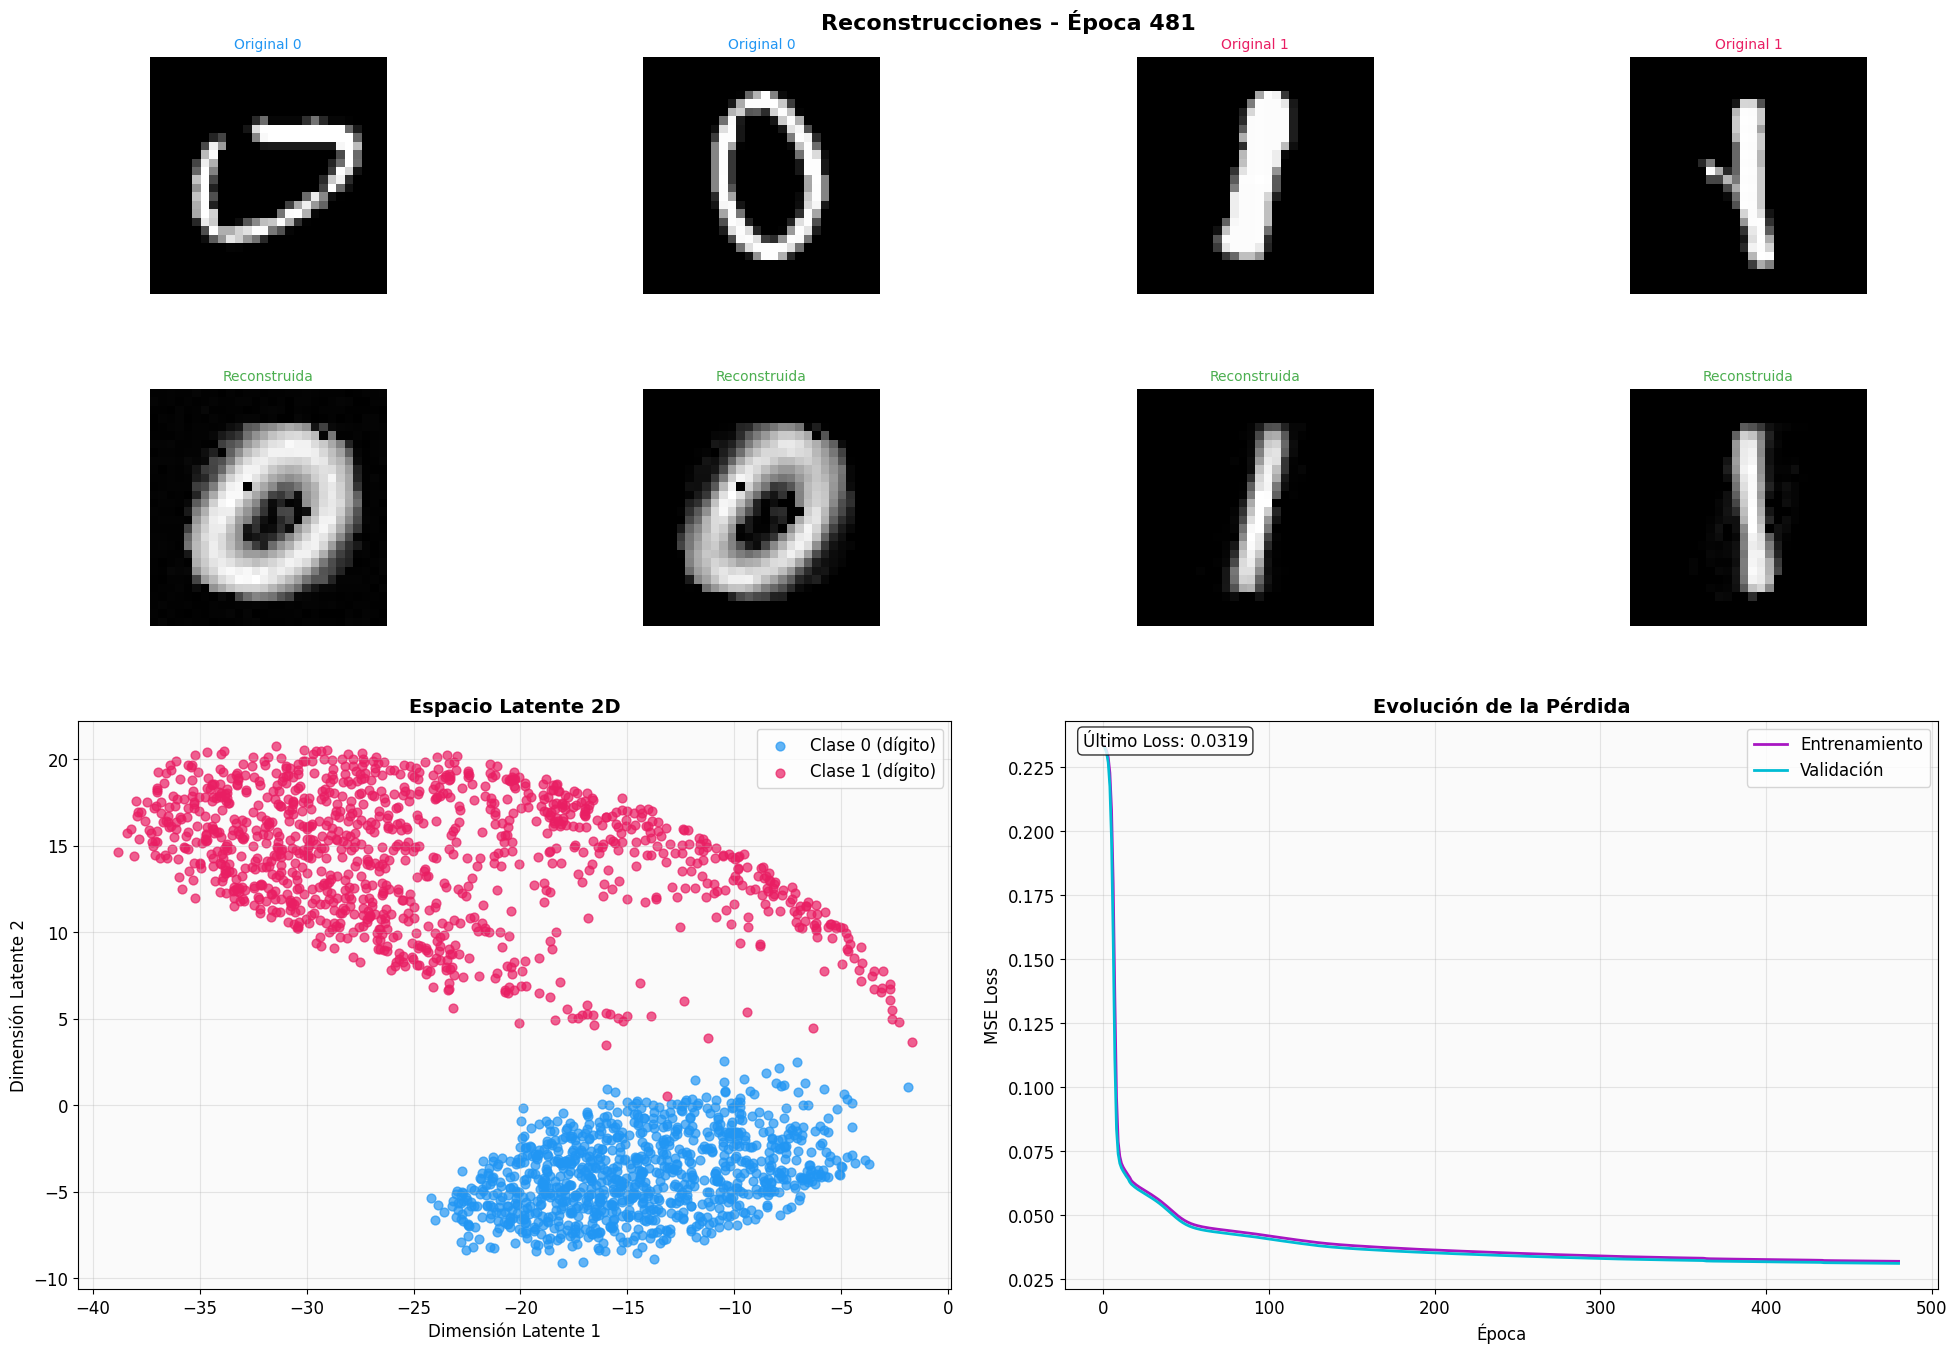

In [ ]:
epochs = 500
batch_size = 32
validation_split = 0.2
learning_rate = 0.01

autoencoder = configurar_entrenamiento(autoencoder, learning_rate=learning_rate)

callback_visualizacion = VisualizacionCallback(
    autoencoder, encoder, decoder,
    x_train, y_train, x_test, y_test,
    frecuencia=20
)


history = autoencoder.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[callback_visualizacion],
    verbose=0)



## 5. Generación de Imágenes desde el Espacio Latente

Una de las capacidades más poderosas de los autoencoders es la **generación de nuevas imágenes** a partir del espacio latente aprendido. En esta sección exploraremos:

### 1. **Interpolación entre Imágenes**
- Crear transiciones suaves entre dos imágenes reales
- Demostrar la continuidad del espacio latente
- Generar "morphing" entre dígitos diferentes

### 2. **Muestreo del Espacio Latente**
- Generar imágenes desde coordenadas arbitrarias
- Crear una "grilla" de imágenes que cubra el espacio latente
- Explorar regiones no ocupadas por datos reales

### 3. **Generación Dirigida**
- Seleccionar coordenadas específicas para generar tipos de dígitos
- Explorar los límites del espacio latente aprendido
- Crear variaciones de dígitos existentes

### Aplicaciones Prácticas

- **Aumento de datos**: Generar nuevos ejemplos para entrenamiento
- **Exploración creativa**: Crear variaciones de imágenes existentes
- **Compresión**: Almacenar imágenes como coordenadas latentes
- **Edición**: Modificar imágenes moviendo puntos en el espacio latente

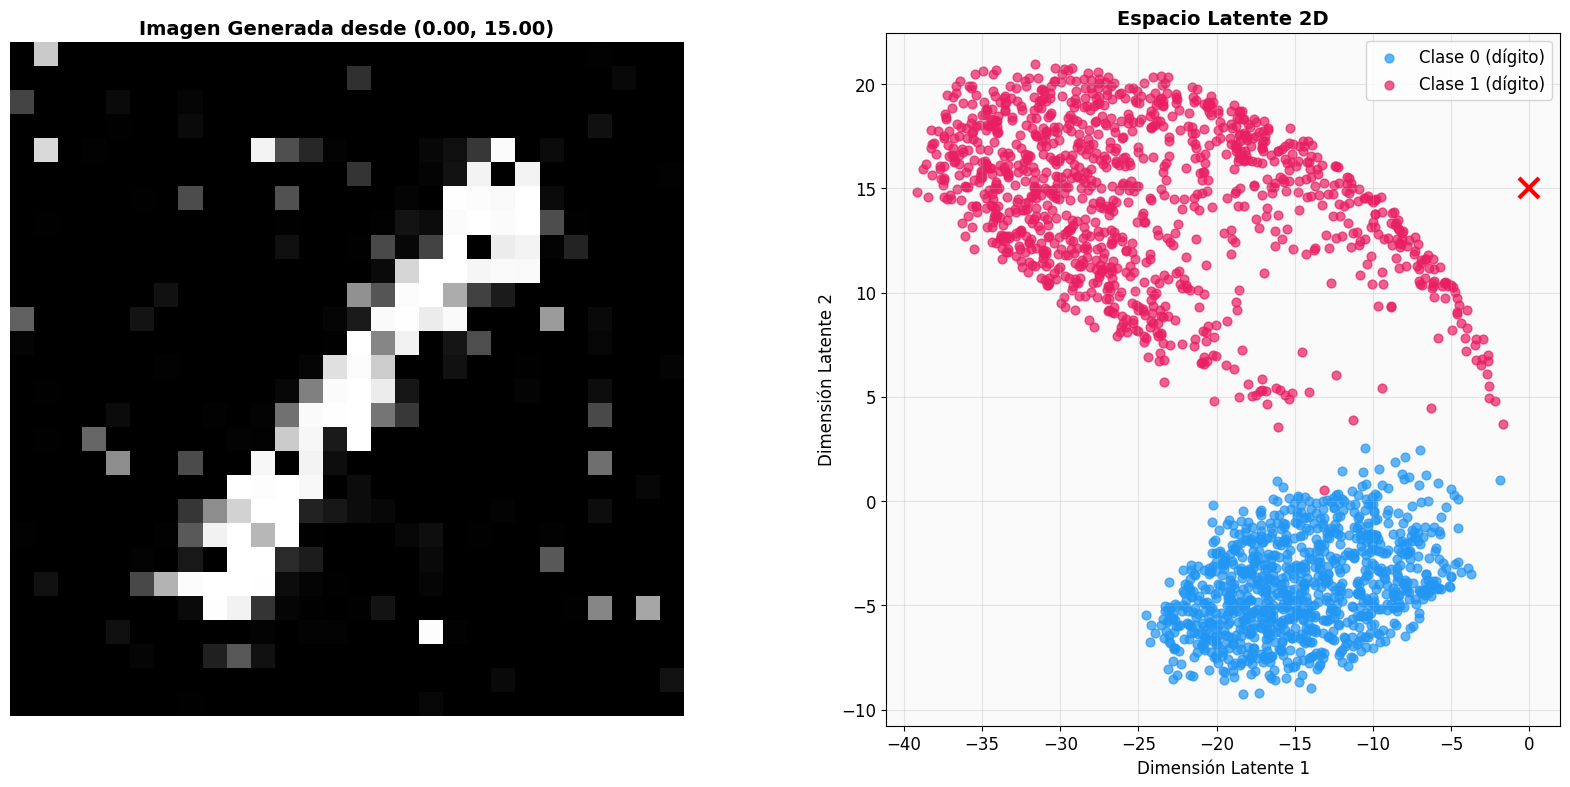

In [ ]:
imagen_custom = generar_imagen_personalizada(decoder, 0.0, 15.0)